<a href="https://colab.research.google.com/github/filipj91/data-science-bootcamp/blob/main/Rosmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


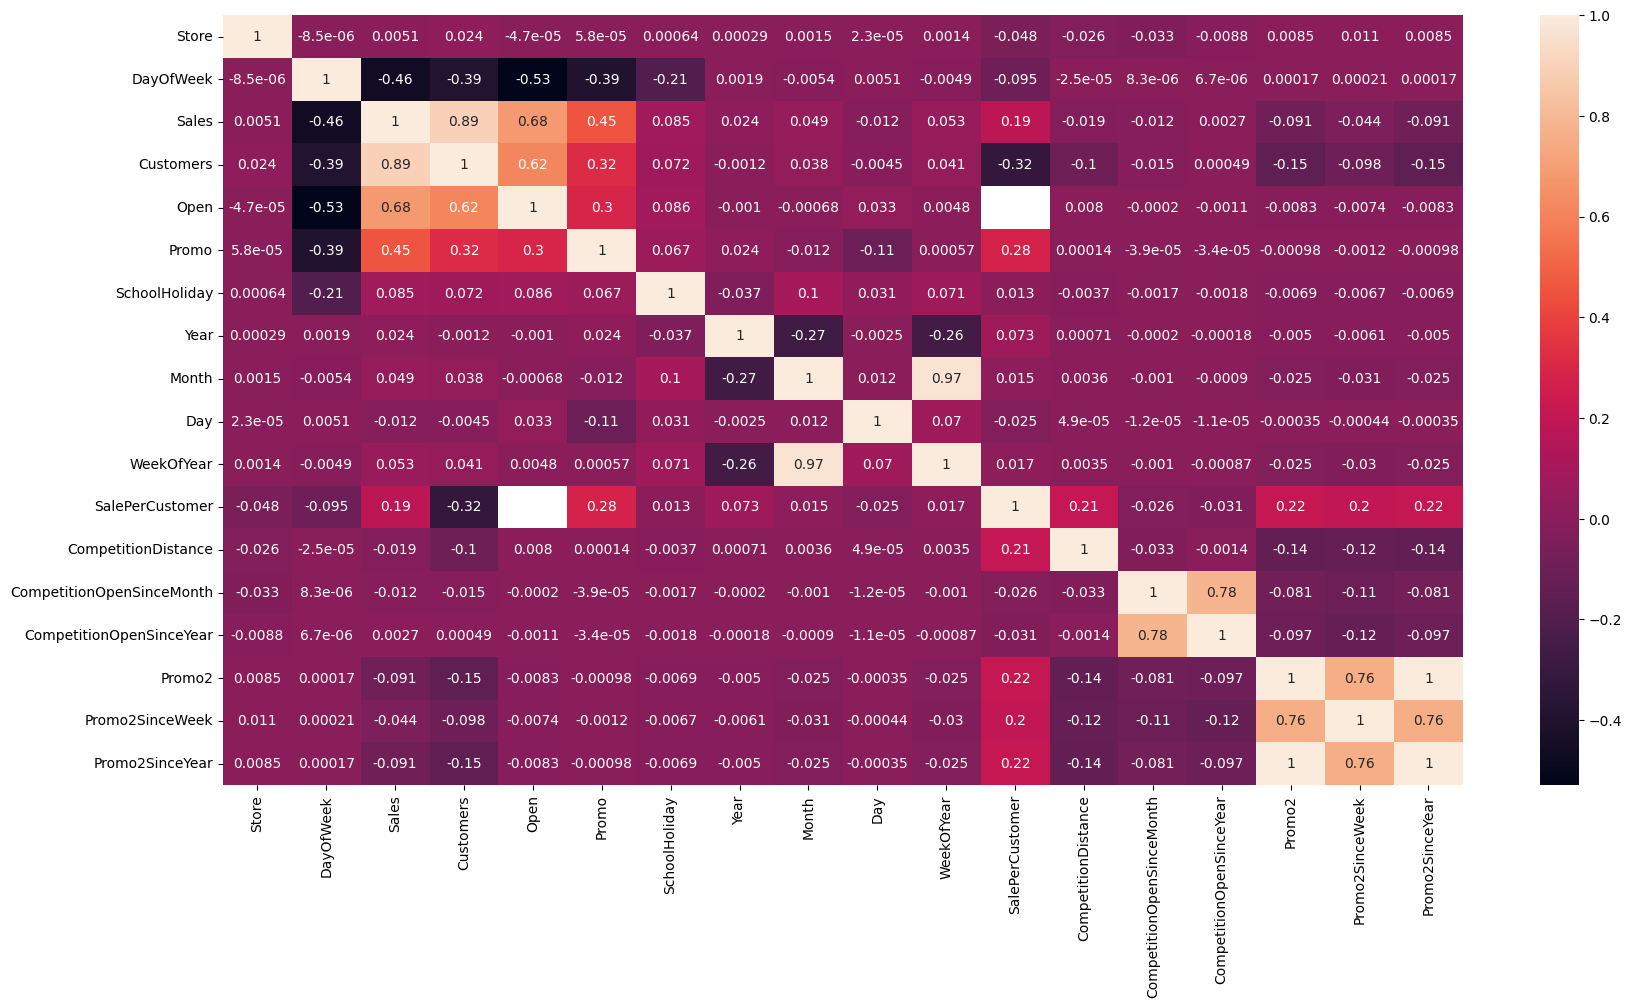

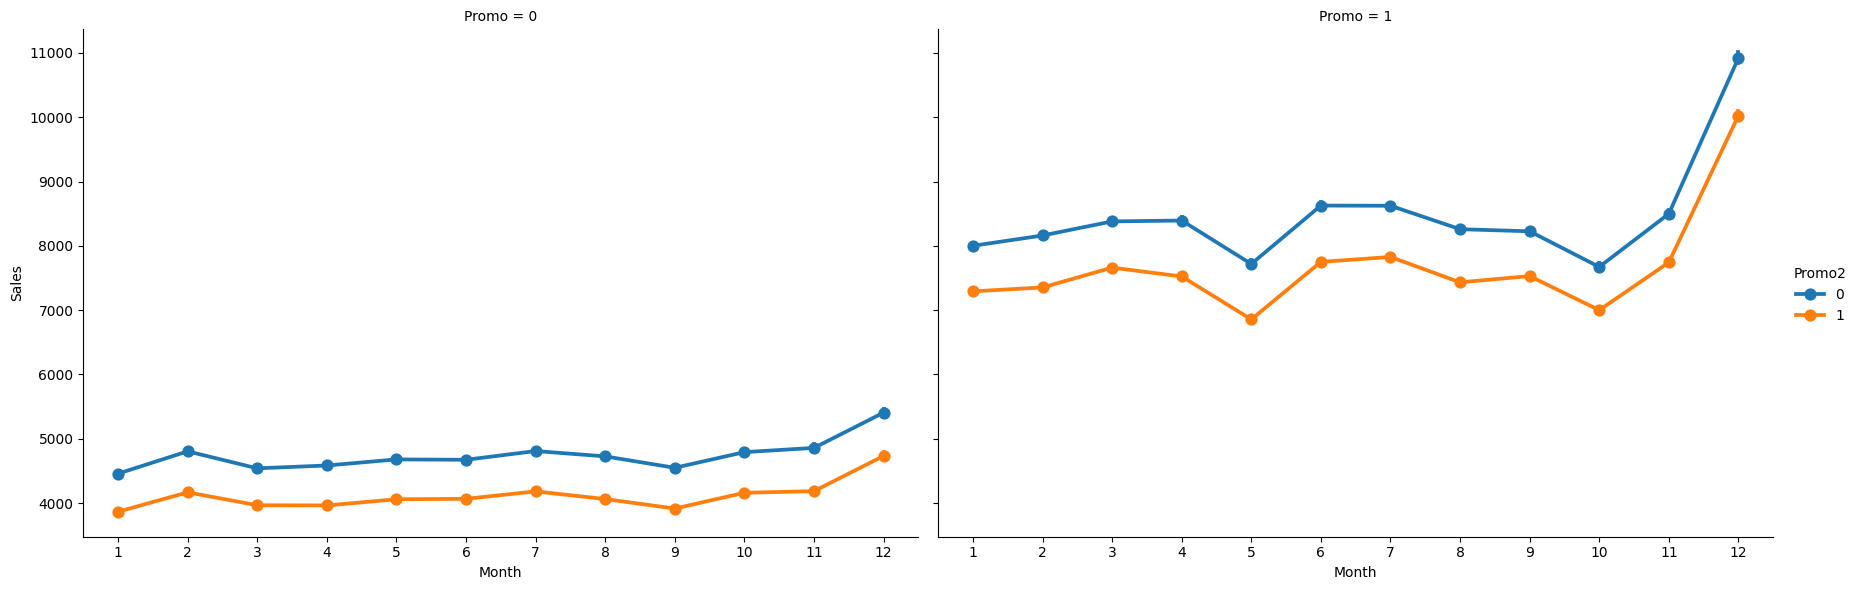

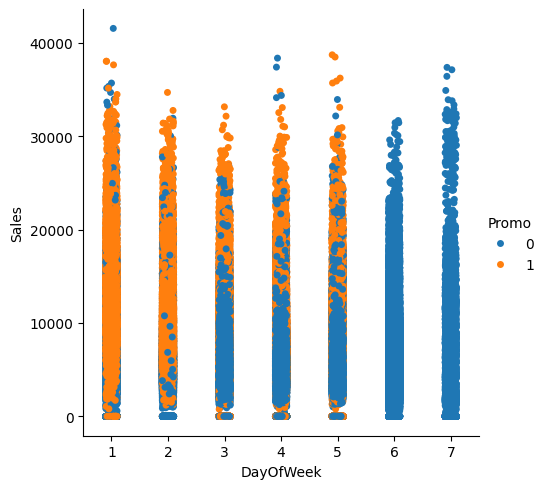

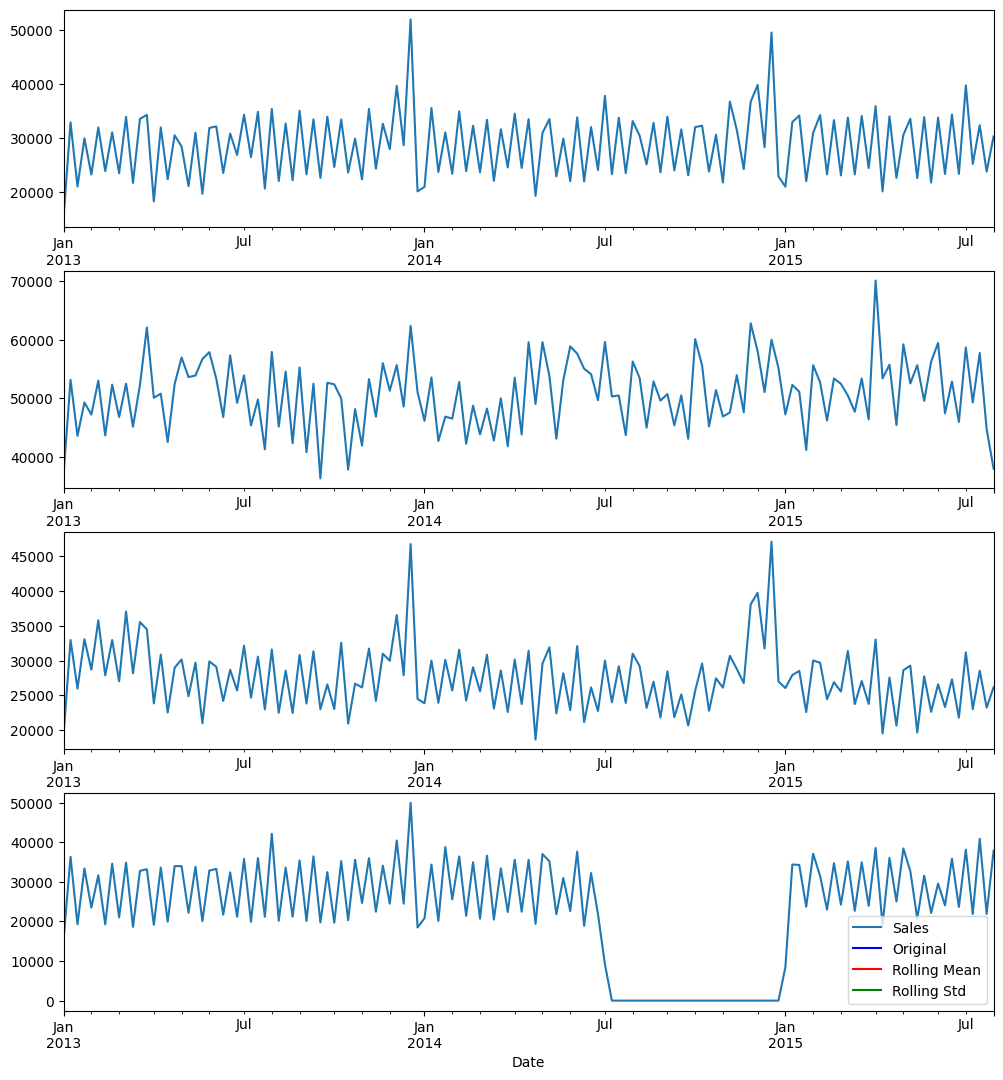

Results of Dickey-Fuller Test:
ADF Statistic: -6.2182369941503275
p-value: 5.30086257084588e-08
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


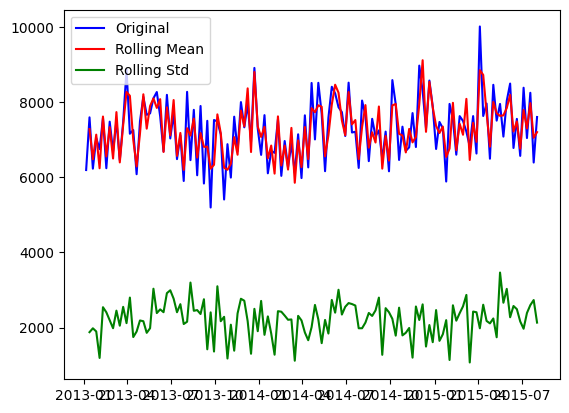

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918100734816
p-value: 9.384455936276692e-07
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


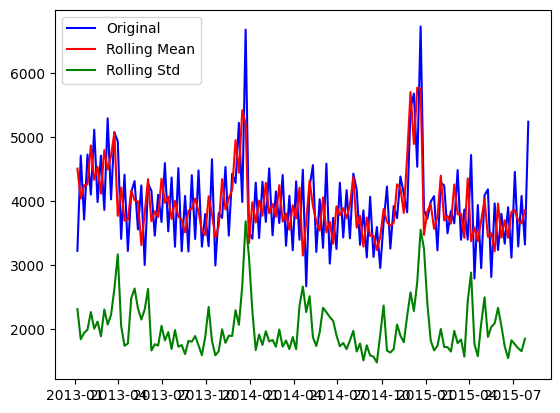

Results of Dickey-Fuller Test:
ADF Statistic: -4.374783612581194
p-value: 0.00032886553525138343
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


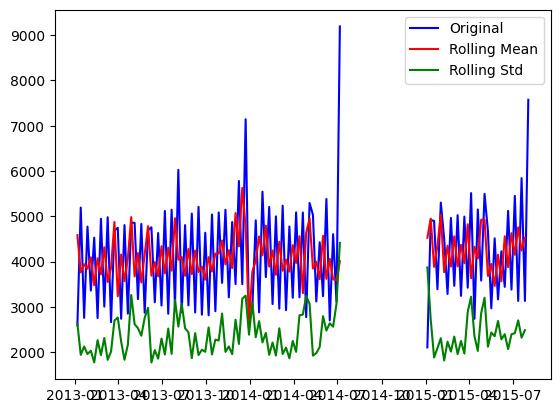

Results of Dickey-Fuller Test:
ADF Statistic: -6.2374610372094255
p-value: 4.7867628477321386e-08
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


TypeError: agg function failed [how->mean,dtype->object]

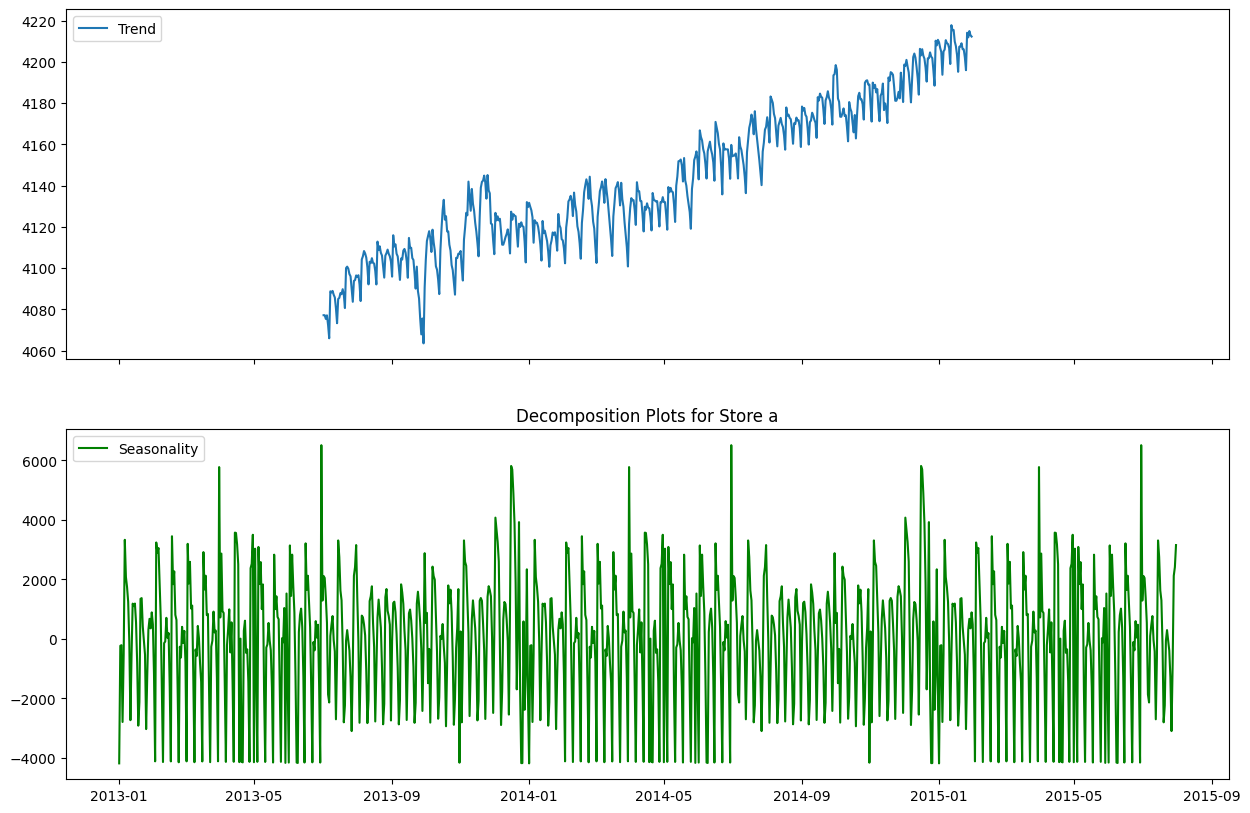

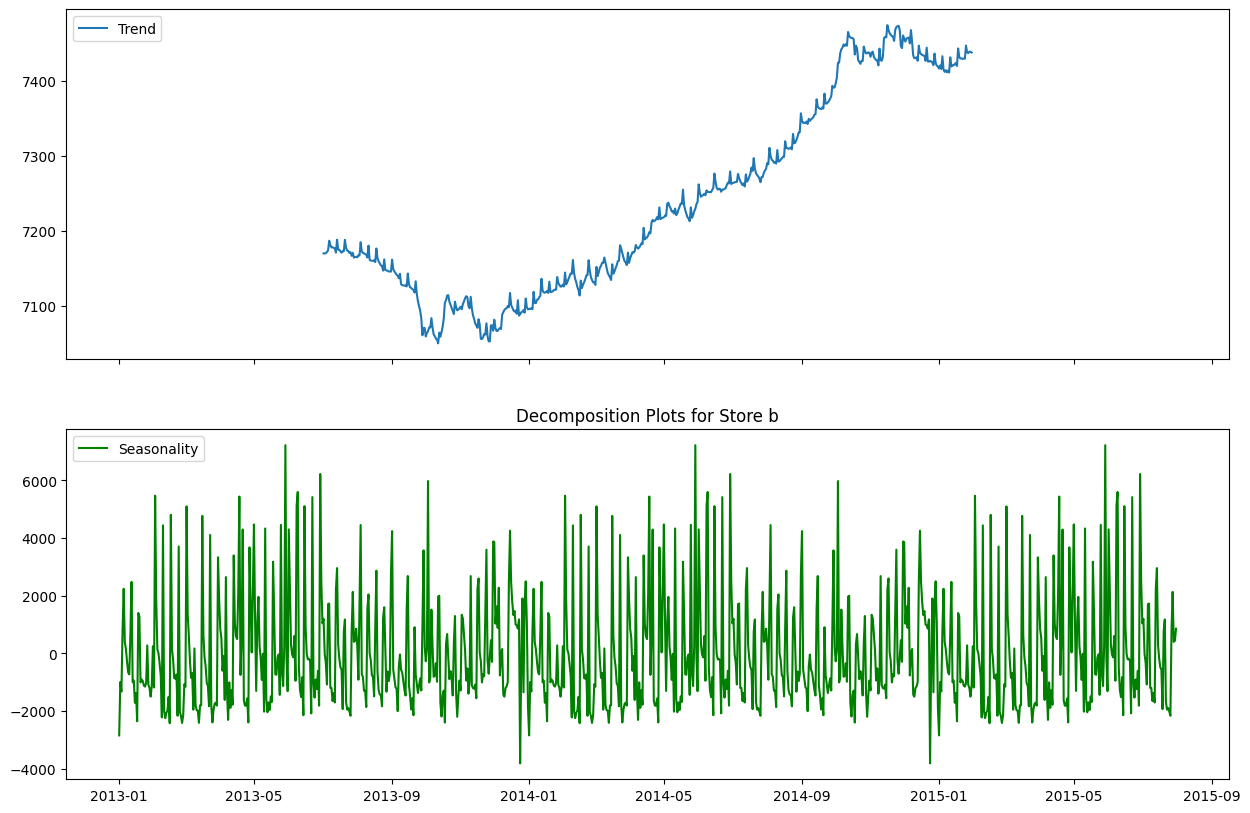

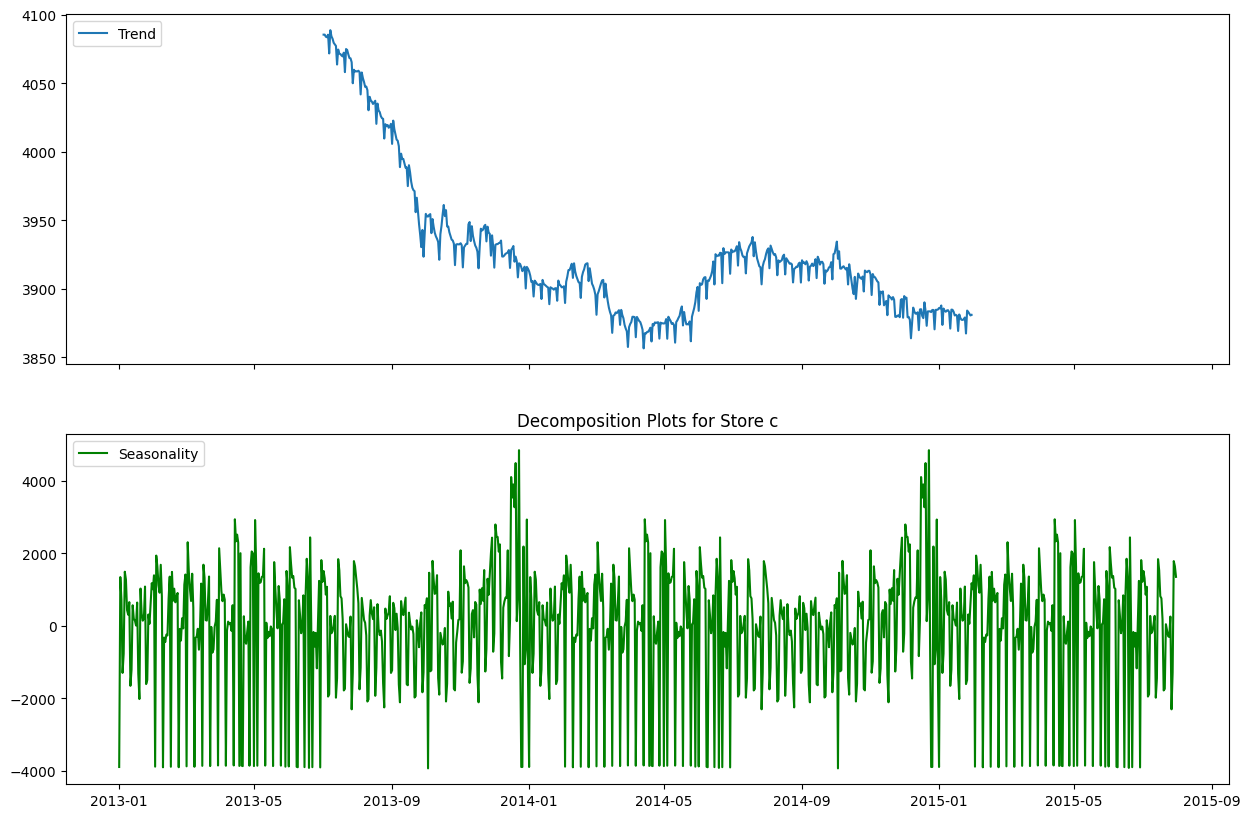

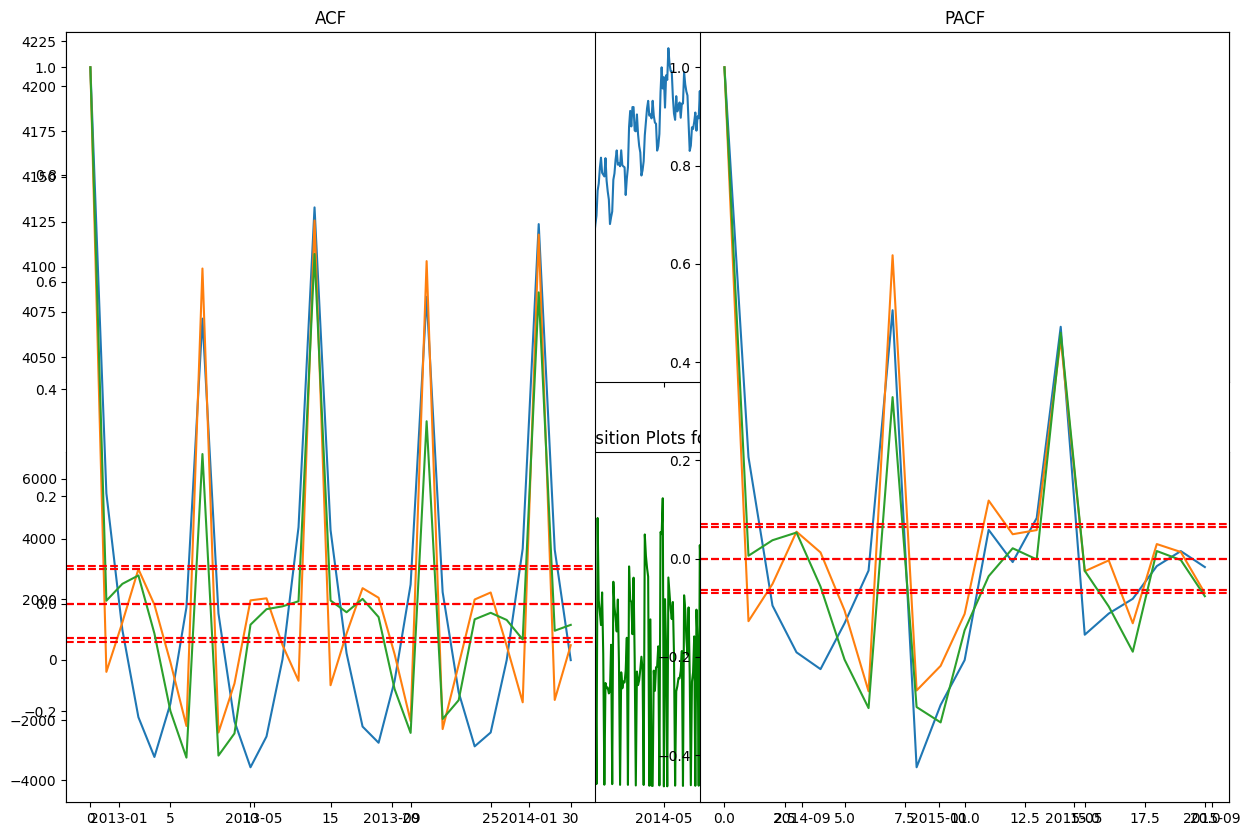

In [ ]:
!pip install prophet
from prophet import Prophet
import numpy as np # linear algebra
import pandas as pd
import os

# Print files in the Kaggle input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load the data
store = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rossmann/store.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rossmann/train.csv', index_col='Date', parse_dates=True)
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rossmann/test.csv')

# Check the data
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week
train['SalePerCustomer'] = train['Sales'] / train['Customers']

# Checking when stores were closed
train_store_closed = train[(train.Open == 0)]

# Checking missing values and filling them
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store.fillna(0, inplace=True)
test.fillna(1, inplace=True)

# Joining the data
train_store_joined = pd.merge(train, store, on='Store', how='inner')

# Plotting the heatmap for correlation
plt.figure(figsize=(20, 10))
numeric_cols = train_store_joined.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

# Updated plotting with sns.catplot()
sns.catplot(data=train_store_joined, x="Month", y="Sales",
            col="Promo",  # per store type in cols
            hue="Promo2",  # color by Promo2
            kind="point",  # Point plot type
            height=6, aspect=1.5)

sns.catplot(data=train_store_joined, x="DayOfWeek", y="Sales", hue="Promo")

# Data Preparation
train['Sales'] = train['Sales'] * 1.0

# Assigning sales for specific stores
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending=True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# Trend for specific stores
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))
sales_a.resample('W').sum().plot(ax=ax1)
sales_b.resample('W').sum().plot(ax=ax2)
sales_c.resample('W').sum().plot(ax=ax3)
sales_d.resample('W').sum().plot(ax=ax4)

# Function to test stationarity
def test_stationarity(timeseries):
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    plt.plot(timeseries.resample('W').mean(), color='blue', label='Original')
    plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    plt.plot(roll_std.resample('W').mean(), color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

# Test stationarity for store types
test_stationarity(sales_a)
test_stationarity(sales_b)
test_stationarity(sales_c)
test_stationarity(sales_d)

# Plotting seasonality and trend
def plot_timeseries(sales, StoreType):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition = seasonal_decompose(sales, model='additive', period=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')

    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')

    plt.title(f'Decomposition Plots for Store {StoreType}')

# Plotting seasonality and trend for store types
plot_timeseries(sales_a, 'a')
plot_timeseries(sales_b, 'b')
plot_timeseries(sales_c, 'c')
plot_timeseries(sales_d, 'd')

# ACF and PACF plots
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales, nlags=20, method='ols')

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('ACF')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('PACF')

# ACF and PACF for store types
auto_corr(sales_a)
auto_corr(sales_c)
auto_corr(sales_d)

# Resampling data for ARIMA
train_arima = train.resample("W").mean()
train_arima = train_arima[["Sales"]]
train_arima.plot()

# Define p, d, q parameters for ARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Check AIC for ARIMA models
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except:
            continue

# Fit the SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                         order=(1, 1, 1),
                                         seasonal_order=(0, 1, 1, 12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

# Check diagnostic plots for SARIMA model
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

# Predictions for validation
pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic=False)
pred_ci = pred.conf_int()

ax = train_arima["2014":].plot(label="observed", figsize=(15, 7))
pred.predicted_mean.plot(ax=ax, label="One-step ahead Forecast", alpha=1)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="k", alpha=0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")
plt.legend()
plt.show()

# Calculate RMSE
train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print(f"Root Mean Squared Error: {rms_arima}")

